## Online Forecasting

This notebook contains code examples from section 3.1.2 in Real-Time Machine Learning.

### Load the data sample

The data sample used in this notebook is a time series collection from OpenSky for a single aircraft over the course of an hour on June 27, 2022. We've included it in this repository to ensure reproducible results for the following code examples.

In [ ]:
import os
import pandas as pd
import urllib.request
from matplotlib import pyplot as plt

# Load the data sample
file_path = 'data/opensky_sample_34718e.csv'
if not os.path.exists(file_path):
    url = "https://raw.githubusercontent.com/pdeziel/real-time-machine-learning/main/ch03/data/opensky_sample_34718e.csv"
    urllib.request.urlretrieve(url, file_path)

# Load the data from the CSV file
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['time'], unit='s')
df['hms'] = df['datetime'].dt.strftime('%H:%M:%S')
df = df[80:]
df.head()

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact,datetime,hms
80,1656288800,34718e,40.007226,0.351937,211.973403,232.295757,4.55168,IBE2601,False,False,False,417.0,9944.10,10424.16,1.656289e+09,1.656289e+09,2022-06-27 00:13:20,00:13:20
81,1656288810,34718e,39.995355,0.331962,211.659167,232.405936,4.22656,IBE2601,False,False,False,417.0,9989.82,10469.88,1.656289e+09,1.656289e+09,2022-06-27 00:13:30,00:13:30
82,1656288820,34718e,39.983903,0.312611,211.251779,232.320815,3.90144,IBE2601,False,False,False,417.0,10035.54,10515.60,1.656289e+09,1.656289e+09,2022-06-27 00:13:40,00:13:40
83,1656288830,34718e,39.972290,0.293030,211.251779,232.320815,0.97536,IBE2601,False,False,False,417.0,10050.78,10538.46,1.656289e+09,1.656289e+09,2022-06-27 00:13:50,00:13:50
84,1656288840,34718e,39.960526,0.273315,211.973403,232.295757,0.32512,IBE2601,False,False,False,417.0,10058.40,10546.08,1.656289e+09,1.656289e+09,2022-06-27 00:14:00,00:14:00


### Online regression loop

This code will produce an overflow error because the input features are not scaled.

In [13]:
import numpy as np

np.random.seed(42)
m, b = np.random.rand(2)
learning_rate = 0.01
for _, row in df.iterrows():
    print(f"m: {m}, b: {b}")
    pred_y = m * row["time"] + b
    print("Predicted: %.3f, Actual: %.3f" % (pred_y, row["velocity"]))
    print("Squared error: ", (pred_y - row["velocity"]) ** 2)
    m = m - 2 * learning_rate * (pred_y - row["velocity"]) * row["time"]
    b = b - 2 * learning_rate * (pred_y - row["velocity"])
    print()

m: 0.3745401188473625, b: 0.9507143064099162
Predicted: 620346604.948, Actual: 211.973
Squared error:  3.848296472769284e+17

m: -2.0549455656093424e+16, b: -12406926.908783037
Predicted: -34035833454778747526840320.000, Actual: 211.659
Squared error:  1.1584379589614362e+51

m: 1.1274634018034736e+33, b: 6.80716669095575e+23
Predicted: 1867405027366261021205435783235918574387200.000, Actual: 211.252
Squared error:  3.487201536232786e+84

m: -6.185924138477064e+49, b: -3.734810054732522e+40
Predicted: -102456770537869340480190954400571853494190537063099942305792.000, Actual: 211.252
Squared error:  1.049738982904961e+118

m: 3.3939600919949215e+66, b: 2.0491354107573867e+57
Predicted: 5621378223776561485673271523432304934724483861092970679426299311234190671872.000, Actual: 211.973
Squared error:  3.159989313474933e+151

m: -1.8621252034920284e+83, b: -1.1242756447553124e+74
Predicted: -308421721184782761118965831707508679171859773263941127035972800758920107685989404967931215872.000, Ac

/var/folders/vz/f5zt7f7j52938fsdxyzn06q80000gn/T/ipykernel_94098/2080601996.py:10: RuntimeWarning: overflow encountered in scalar power
  print("Squared error: ", (pred_y - row["velocity"]) ** 2)
/var/folders/vz/f5zt7f7j52938fsdxyzn06q80000gn/T/ipykernel_94098/2080601996.py:8: RuntimeWarning: overflow encountered in scalar multiply
  pred_y = m * row["time"] + b
/var/folders/vz/f5zt7f7j52938fsdxyzn06q80000gn/T/ipykernel_94098/2080601996.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  m = m - 2 * learning_rate * (pred_y - row["velocity"]) * row["time"]
/var/folders/vz/f5zt7f7j52938fsdxyzn06q80000gn/T/ipykernel_94098/2080601996.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  b = b - 2 * learning_rate * (pred_y - row["velocity"])


### Scaling values in an online fashion

In [14]:
class OnlineStandardScaler:
    def __init__(self):
        self.mean = 0
        self.var = 0
        self.n = 0

    def update(self, x):
        self.n += 1
        new_mean = self.mean + (x - self.mean) / self.n
        new_var = self.var + (x - self.mean) * (x - new_mean)
        self.mean, self.var = new_mean, new_var

    def scale(self, x):
        if self.n < 2:
            return 0
        if self.var == 0:
            return 0
        return (x - self.mean) / np.sqrt(self.var / (self.n - 1))
    
    def update_and_scale(self, x):
        self.update(x)
        return self.scale(x)

### Augmenting the online regression loop with online scaling

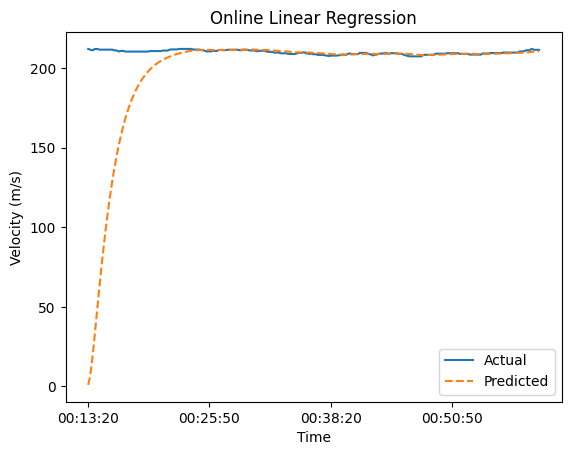

In [ ]:
import numpy as np

np.random.seed(42)
m, b = np.random.rand(2)
learning_rate = 0.01
scaler = OnlineStandardScaler()
predicted_values = []
for _, row in df.iterrows():
    t = scaler.update_and_scale(row["time"])
    pred_y = m * t + b
    gradient = 2 * (pred_y - row["velocity"])
    m -= learning_rate * gradient * t
    b -= learning_rate * gradient
    predicted_values.append(pred_y)

fig, ax = plt.subplots()
ax.set_title('Online Linear Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Velocity (m/s)')
ax.set_xticks(range(0, len(df), 75))
ax.plot(df["hms"], df["velocity"], label='Actual')
ax.plot(df["hms"], predicted_values, label='Predicted', linestyle='dashed')
ax.legend()

### Online linear regressor

In [16]:
import numpy as np

class OnlineLinearRegressorV1:
    def __init__(self, scaler=OnlineStandardScaler(), learning_rate=0.01, initial_weights=None):
        self.scaler = scaler
        self.learning_rate = learning_rate
        self.weights = np.array(initial_weights) if initial_weights else np.random.rand(2)

    def predict_one(self, x):
        x = self.scaler.scale(x)
        return self.weights[0] * x + self.weights[1]
    
    def learn_one(self, x, y, y_pred=None):
        if y_pred is None:
            y_pred = self.predict_one(x)
        x = self.scaler.update_and_scale(x)
        gradient = np.array([2 * x * (y_pred - y), 2 * (y_pred - y)])
        self.weights -= self.learning_rate * gradient

### Online linear regression with different learning rates

Learning rate: 0.001
	MAE: 0.995163
	MSE: 1.417248
	RMSE: 1.190482
Learning rate: 0.01
	MAE: 0.658552
	MSE: 0.662950
	RMSE: 0.814217


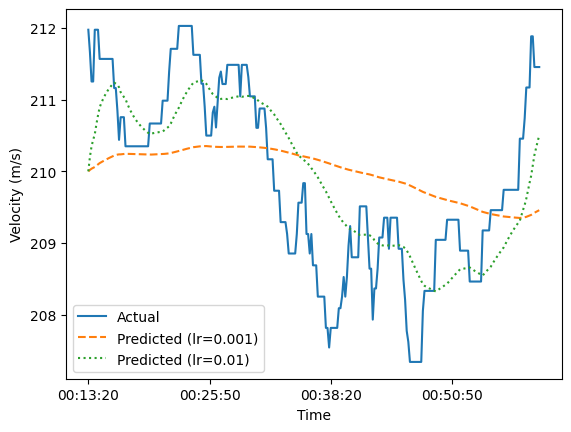

In [ ]:
initial_weights = [0, 210.0]
models = [
    OnlineLinearRegressorV1(learning_rate=0.001, initial_weights=initial_weights),
    OnlineLinearRegressorV1(learning_rate=0.01, initial_weights=initial_weights)
]
true_values = df["velocity"]
predicted_values = [[] for _ in models]
for _, row in df.iterrows():
    x = row["time"]
    y = row["velocity"]
    for i in range(len(models)):
        y_pred = models[i].predict_one(x)
        models[i].learn_one(x, y)
        predicted_values[i].append(y_pred)

fig, ax = plt.subplots()
ax.plot(df["hms"], true_values, label="Actual")
ax.set_xlabel('Time')
ax.set_ylabel('Velocity (m/s)')
linestyles = ['dashed', 'dotted']
for i in range(len(models)):
    ax.plot(df["hms"], predicted_values[i], label=f"Predicted (lr={models[i].learning_rate})", linestyle=linestyles[i])
    print(f"Learning rate: {models[i].learning_rate}")
    print("\tMAE: %.6f" % (sum(abs(true_values - predicted_values[i]) / len(true_values))))
    print("\tMSE: %.6f" % (sum((true_values - predicted_values[i]) ** 2) / len(true_values)))
    print("\tRMSE: %.6f" % ((sum((true_values - predicted_values[i]) ** 2) / len(true_values)) ** 0.5))
ax.set_xticks(range(0, len(df), 75))
ax.legend()

### Plotting rolling MAE for different learning rates

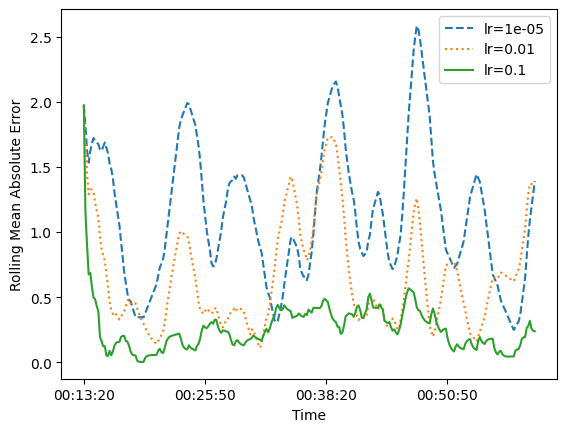

In [ ]:
initial_weights = [0, 210.0]
models = [
    OnlineLinearRegressorV1(learning_rate=1e-5, initial_weights=initial_weights),
    OnlineLinearRegressorV1(learning_rate=1e-2, initial_weights=initial_weights),
    OnlineLinearRegressorV1(learning_rate=0.1, initial_weights=initial_weights),
]
true_values = df["velocity"]
predicted_values = [[] for _ in models]
abs_errors = [[] for _ in models]
mae_values = [[] for _ in models]
for _, row in df.iterrows():
    x = row["time"]
    y = row["velocity"]
    for i in range(len(models)):
        y_pred = models[i].predict_one(x)
        abs_errors[i].append(abs(y_pred - y))
        abs_errors[i] = abs_errors[i][-10:]
        mae_values[i].append(sum(abs_errors[i]) / len(abs_errors[i]))
        models[i].learn_one(x, y)
        predicted_values[i].append(y_pred)

fig, ax = plt.subplots()
ax.set_xlabel('Time')
ax.set_ylabel('Rolling Mean Absolute Error')
linestyles = ['dashed', 'dotted', 'solid']
for i in range(len(models)):
    ax.plot(df["hms"], mae_values[i], label=f"lr={models[i].learning_rate}", linestyle=linestyles[i])
ax.set_xticks(range(0, len(df), 75))
ax.legend()

### Forecasting with the online linear regression model

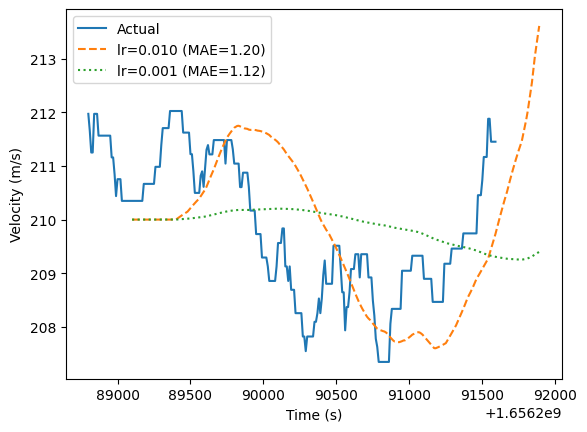

In [ ]:
forecast_seconds = 60 * 5
initial_weights = [0, 210.0]
models = [
    OnlineLinearRegressorV1(learning_rate=0.01, initial_weights=initial_weights),
    OnlineLinearRegressorV1(learning_rate=0.001, initial_weights=initial_weights),
]
true_values = [np.array([]) for _ in models]
predicted_values = [{} for _ in models]
for _, row in df.iterrows():
    x = row["time"]
    y = row["velocity"]
    for i in range(len(models)):
        predicted_values[i][x + forecast_seconds] = models[i].predict_one(x + forecast_seconds)
        if x in predicted_values[i]:
            true_values[i] = np.append(true_values[i], y)
            models[i].learn_one(x, y, y_pred=predicted_values[i][x])

fig, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')
ax.plot(df["time"], df["velocity"], label="Actual")
linestyles = ['dashed', 'dotted', 'solid']
for i in range(len(models)):
    preds = sorted(predicted_values[i].items())
    x, y = zip(*preds)
    mae = sum(abs(true_values[i] - y[:len(true_values[i])]) / len(true_values[i]))
    ax.plot(x, y, label="lr=%.3f (MAE=%.2f)" % (models[i].learning_rate, mae), linestyle=linestyles[i])
ax.legend()